# Final Assignment
By Borna Bengez, Donghyeok Lee, Paula Dodig, Philipp Merz<br><br>

## Practical Part
# Problem Framing
Our task is to predict the churn status of a customer based on corresponding features described in the image below.  
![Dataset columns](https://i.ibb.co/gTjBfCn/Screenshot-from-2020-04-20-15-03-29.png")
As shown in the image, the dataset relates whether a customer left a company (1) or not (0), which I'll call the churn status (CHS) in the following, to various predictor variables. In order to predict the CHS properly, a number of questions have to be considered:  
1. Are all the features relevant? Are there ID features, near-0 variance features or features that don't make sense to use as predictor features?
2. How do we treat missing values? Do we simply remove rows with missing values, do we impute them using the mean / median?
3. Do we have to scale any features?
4. How do we encode categorical features in the dataset?
5. How do we measure performance? If the data is imbalanced, what metric do we use? Can we use the AUC score as a metric or do we also have to consider other measures of performance?
6. Related to #1, which features do we discard? Can we use any dimensionality reduction features? How do we select important features?  

Most of these questions can be answered after exploring the data in the next section.  
The learning problem is a supervised one, as our training data is labelled. Because we have to train a model to predict classes as opposed to a continuous variable, and we have to use a supervised learning algorithm, we can already exlude some learners, including unsupervised learning algorithms.  
The dataset is relatively simple in terms of domain-specific knowledge needed to solve the given problem, which means that we won't need help from domain experts.  
After having concluded the problem framing section, let's jump into the data exploration.
# Data Exploration
We uploaded the dataset to a third party hosting website in order to make the collaboration process easier. This changes neither the dataset itself nor does it impact the other sections in any way.



(TODO FOR BORNA)
2. Fix the error given by LogisticRegression(Find a way to make it happy with less iterations, probably an alternative solver)
3. Find a way to do this on GPU because processing time not fun
4. Remove logistic regression

In [5]:
#Import relevant modules
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math

In [56]:
#Get the data
df = pd.read_csv('http://www.sharecsv.com/dl/d68569bfae8a6d5d8d6c5435a98f0e3e/churn_train.csv')

In [57]:
#Get a broad overview, test if data is imported correctly
df.head()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,45.0,106,1.0,1395,0.0,0.0,0,235.2,121,39.98,...,87,18.75,236.3,91,10.63,11.8,4.0,3.19,1.0,0
1,44.0,51,0.0,4191,0.0,1.0,0,212.9,80,36.19,...,57,20.07,187.6,99,8.44,8.8,4.0,2.38,2.0,0
2,10.0,64,2.0,4508,0.0,0.0,0,216.9,78,36.87,...,115,17.94,179.8,116,8.09,11.4,5.0,3.08,3.0,0
3,31.0,59,2.0,1041,1.0,1.0,31,225.0,78,38.25,...,79,16.26,226.7,79,10.20,9.1,3.0,2.46,NaN,0
4,8.0,136,1.0,1349,0.0,0.0,0,101.7,105,17.29,...,99,17.24,136.2,119,6.13,9.4,6.0,2.54,3.0,0


In [58]:
print("Columns:", df.columns)
print("Dimensions:", df.shape[0], "rows and", df.shape[1], "columns")

Columns: Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')
Dimensions: 4000 rows and 21 columns


# Data Exploration

From inspecting the column names, the phone number column wouldn't seem to be able to contribute to predict the churn rate as it can't be treated as a continuous, numeric variable, and most certainly isn't connected to the customers churn rate in any way. Because every customer has a different phone number, this feature can be treated as an ID variable. The same applies to the area code. Because ID variables won't be able to contribute to the prediction, we'll discard these variables from the training features.



In [59]:
#Keep track of what cols to remove
X_remove = ['phone_number', 'area_code']

Next, let's check for the variance of our features, since 0 or near-0 variance features won't contribute anything to the model's performance.

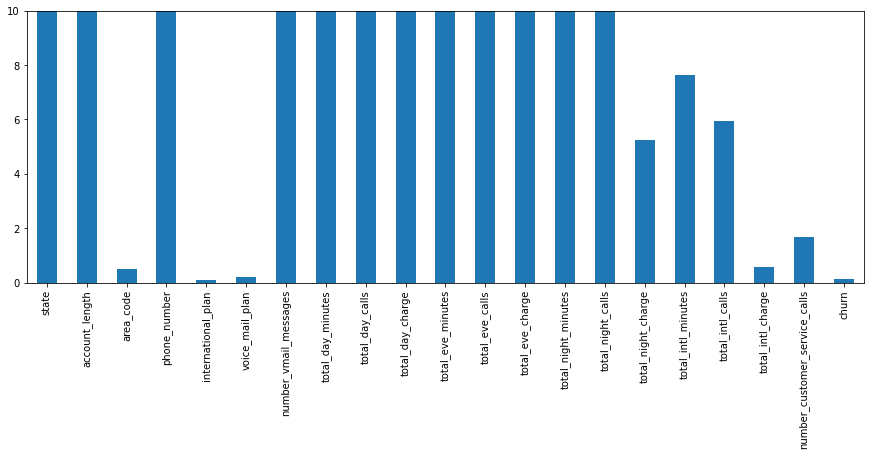

In [60]:
plt.figure(figsize=(15,5))
df.var().plot(kind='bar', ylim=(0,10))

As shown in the plot above, the only near-0 variance features are dichotomous categorical features varying between zero and one, which explaines the low variance relative to other features. In this case, the low variances thus don't tell us anything about those features' information densities, so we won't remove them as we don't want to risk information loss.
The only other features with a low variance are the total international charge and the number of customer service calls features. In case of the total international charge, the low variance can be explained by the fact that most customers don't call foreign numbers often, thus not being charged often. The same applies for the number of customer service calls: As most customers don't call the customer service often, the variance of this feature is low. However, dissatisfied customers might call the customer service more often, in which case this could turn out to be an important predictor, so removing it could impact the model negatively. We're also going to find out more about the international charge feature before deciding whether to remove it.  
Summarizing the variance inspection, there are no features with a low enough variance to justify removing them.  
Next, let's find out if we have to deal with missing values: 

In [61]:
df.isna().sum()[df.isna().sum() > 0]

area_code                         189
total_intl_calls                 1076
number_customer_service_calls     339
dtype: int64

Seems like there's 3 columns where we have to deal with missing values: area_code, total_intl_calls and number_customer_service_calls. We already decided on removing the area_code feature, leaving two columns, which we'll remove in the [Data Preprocessing](https://colab.research.google.com/drive/1iezA3TVxvkWddUoNvT8O8Nj1enEUJKL4#scrollTo=DscvCclhsZP_&line=4&uniqifier=1) section.<br>
Having explored potential missing values, we can also take a look at the correlation matrix of our dataframe in order to find out if there's linearly dependent features, which we could remove in order  to inrease information density of our data to speed up the training time of our models later on:

In [62]:
C = df.drop(X_remove, axis=1).corr()
C

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
state,1.000000,0.003513,0.011494,-0.018783,-0.015936,0.016155,-0.015254,0.016156,0.010843,-0.018728,0.010841,0.010900,0.011504,0.010900,-0.010167,0.015736,-0.010179,-0.021471,0.004918
account_length,0.003513,1.000000,0.019241,-0.006118,-0.012586,0.016350,0.014147,0.016343,-0.016113,0.004641,-0.016107,0.004272,-0.002164,0.004270,0.004914,0.003646,0.004927,0.002826,0.028914
international_plan,0.011494,0.019241,1.000000,0.008984,0.008214,0.033676,0.014397,0.033677,0.015196,0.001709,0.015194,-0.035088,0.012622,-0.035106,0.037087,-0.015320,0.037038,-0.009878,0.259735
voice_mail_plan,-0.018783,-0.006118,0.008984,1.000000,0.955515,0.011676,0.004742,0.011672,0.013618,0.004103,0.013614,0.019516,0.001114,0.019514,-0.001354,-0.011262,-0.001288,-0.008019,-0.117851
number_vmail_messages,-0.015936,-0.012586,0.008214,0.955515,1.000000,0.017926,0.006385,0.017922,0.010221,0.007188,0.010220,0.018582,-0.001993,0.018575,-0.003308,-0.003436,-0.003250,-0.006125,-0.109572
total_day_minutes,0.016155,0.016350,0.033676,0.011676,0.017926,1.000000,-0.008437,1.000000,0.003441,0.001353,0.003424,0.016098,0.013053,0.016079,-0.020382,-0.008187,-0.020321,0.014543,0.227877
total_day_calls,-0.015254,0.014147,0.014397,0.004742,0.006385,-0.008437,1.000000,-0.008439,0.005256,0.010696,0.005271,0.003384,-0.015274,0.003390,0.009566,0.005312,0.009610,-0.014693,0.028430
total_day_charge,0.016156,0.016343,0.033677,0.011672,0.017922,1.000000,-0.008439,1.000000,0.003443,0.001354,0.003427,0.016103,0.013054,0.016085,-0.020388,-0.008195,-0.020326,0.014535,0.227871
total_eve_minutes,0.010843,-0.016113,0.015196,0.013618,0.010221,0.003441,0.005256,0.003443,1.000000,-0.000709,1.000000,-0.024282,0.017481,-0.024294,0.000731,0.006359,0.000783,-0.005460,0.099741
total_eve_calls,-0.018728,0.004641,0.001709,0.004103,0.007188,0.001353,0.010696,0.001354,-0.000709,1.000000,-0.000695,-0.004045,-0.022881,-0.004029,0.000539,-0.016859,0.000447,0.001229,-0.005107


This correlation matrix is hard to visually comprehend, so let's plot it as a heatmap:

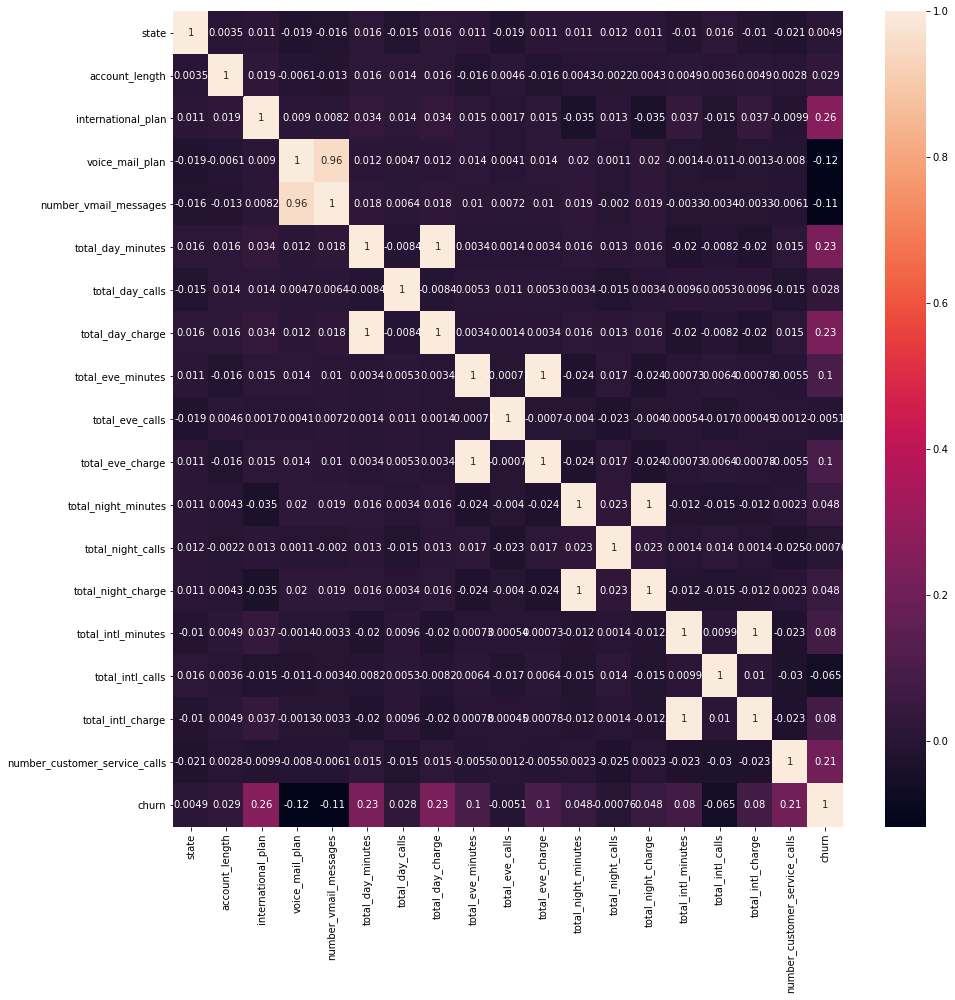

In [63]:
plt.figure(figsize=(15,15))
sb.heatmap(C, annot=True)

As we can see in the heatmap, there's a number of columns with a correlation coefficient of one, meaning these pairs of features depend on each other linearly. When taking a look at the names of the columns, we can see that the pairs of linearly dependent features always combine cost and number / length of calls for a customer. The total correlation makes sense as phone companies charge their customers per minute, so the longer a customer is on a call, the more they're charged for the call.  <br>
The last thing to check for are outliers, so let's boxplot all the features first:

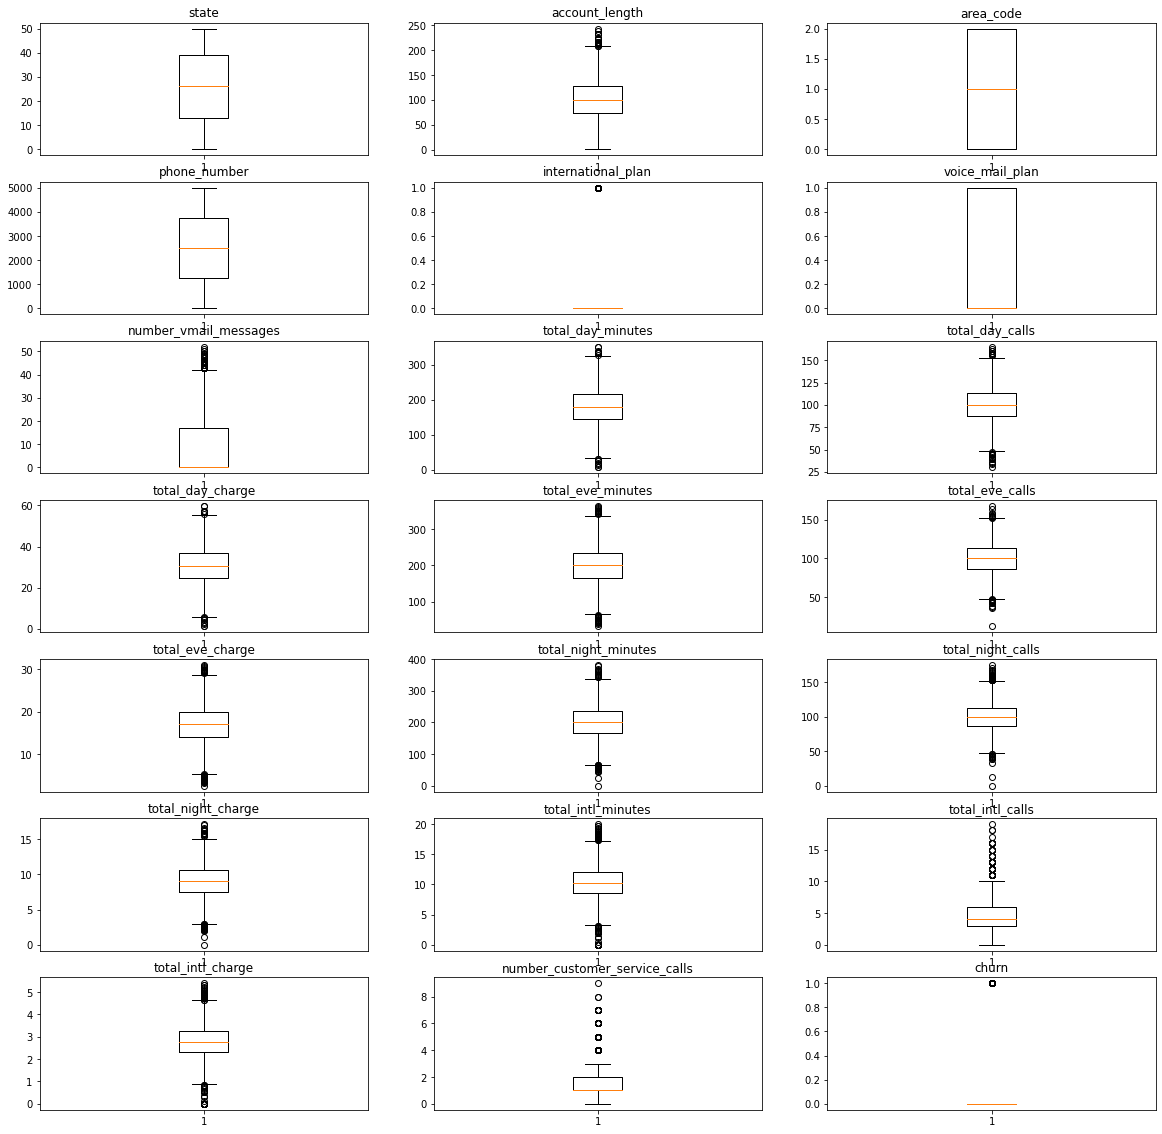

In [64]:
#Figure for 21 boxplots, one for every column
fig, ax = plt.subplots(7, 3)
fig.set_size_inches(20, 20)

i = 0
for column in df:
  #Drop NaNs because otherwise boxplot can't display
  ax[math.floor(i/3), i%3].boxplot(df[column].dropna());
  ax[math.floor(i/3), i%3].set_title(column)
  i += 1

After taking a look at the boxplot matrix, we can conclude that there aren't any values large enough to remove, so removing outliers isn't necessary.  
Next, let's check if and how unbalanced the data is, as probably most customers won't leave their phone company.

In [65]:
no_churn = df[df['churn'] == 0]['churn'].count()
churn = df.shape[0] - no_churn 
print(no_churn, 'customers stayed and', churn, 'customers left the company.')
print('Churn rate:', churn/df.shape[0])

3434 customers stayed and 566 customers left the company.
Churn rate: 0.1415


As expected, the data is imbalanced with most customers' churn status at zero meaning no churn. This raises the question of which metric to use for measuring the performance of the model, as the usual accuracy score wouldn't represent the usefulness of the model due to the imbalance: A model that only predicts a churn status of 0, meaning regardless of the input, it'd only predict that customers will stay with the company, would still have a high accuracy score. Thus, the model would predict a large number of false positives (people staying with the company although they'd leave in reality), which is not desireable.  
Another metric that's more suited for working with imbalanced data on classifiers is the AUC score. AUC is short for **A**rea **U**nder **C**urve, and represents the area under the Receiver Operating Characteristic Curve (ROC). Instead of measuring performance via accuracy of predictions directly, the ROC uses the True Positive Rate (TPR) plotted against the False Positve Rate (FPR). If a datasets' two categories are perfectly linearly separable, and the model finds the ideal separator, the ROC curve looks like this:  
![From https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5](https://miro.medium.com/max/552/1*HmVIhSKznoW8tFsCLeQjRw.png)  
In this case, the AUC score, that is the integral of the ROC on the interval [0;1], is the maximum AUC score possible, so 1. This means that the model can perfectly predict every category and does not predict false negatives or positives.  
In most cases though, the data isn't perfectly linearly separable, so the model has to tolerate some amount of False Positives depending on the treshold at which a category as classified as such. Generally, the more the tolerance towards False Positives, the higher the number of True Positives detected by the model, and inversely, in order to decrease the number of False Positives, the model also has to decrease its ability to predict True Positives.  
This is a payoff that has to be balanced by choosing the right threshold at which Negatives and Positives are classified, but because the ROC curve considers no individual threshold, the AUC score reports a model's performance independently of the chosen threshold.  
Additionally, because the AUC score doesn't only consider the TPR, but also the FPR, it can handle imbalanced data as well as balanced data. In the previously described situation where the model always predicts the same category independently of the input, the AUC score would be low since the FPR would be just as high as the TPR.  
Since our dataset is rather imbalanced, we'll use the AUC score to report model performance. 

# Data Preprocessing
Let's start by defining a function that removes both the ID columns noted in X_remove and one of each linearly-dependent columns. We'll use this function later to automatically transform the test dataset in the same way.

In [66]:
def remove_linearly_dependent(data):
  #First, drop X_remove ID features
  data = data.drop(X_remove, axis=1)

  #Define correlation matrix for input
  C = data.corr()

  #Define boolean mask for columns we want to keep
  columns = np.full((C.shape[0],), True, dtype=bool)

  #For every distinct entry in correlation matrix
  for i in range(C.shape[0]):
    for j in range(i+1, C.shape[0]):
      #If the correlation coef is above .9 and 
      if C.iloc[i,j] >= 0.9 and columns[j]:
        columns[j] = False
  selected_columns = data.columns[columns]
  return data[selected_columns]

In [67]:
#Apply function on dataset
df_clean = remove_linearly_dependent(df)

In [68]:
#Check difference
print(df_clean.columns)
print("Dimensions:", df_clean.shape[0], "rows and", df.shape[1], "columns")

Index(['state', 'account_length', 'international_plan', 'voice_mail_plan',
       'total_day_minutes', 'total_day_calls', 'total_eve_minutes',
       'total_eve_calls', 'total_night_minutes', 'total_night_calls',
       'total_intl_minutes', 'total_intl_calls',
       'number_customer_service_calls', 'churn'],
      dtype='object')
Dimensions: 4000 rows and 21 columns


Next, we'll inspect  the option for imputing the missing values.
As the number of rows with missing values in the total_intl_calls is about 25% of the total number of rows in the dataset, simply removing the rows in question would cause a data loss to big to justify, so another option is needed.  
Another way of dealing with missing values is missing value imputation, for which scikit-learn conveniently has packages for: SimpleImputer, which we could use to impute the missing values with means, medians or modes of the corresponding feature, or [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html), which estimates the missing values of a feature based on the other features, and has been shown to [work well](https://medium.com/analytics-vidhya/using-scikit-learns-iterative-imputer-694c3cca34de), so we'll try using this method of imputing. This will impute all missing values, so we're imputing both total_intl_calls _and_ number_customer_service_calls.  
An important condition for using IterativeImputer is to only impute continuous data, since this method of imputing could also fill non-integer numbers, which wouldn't make sense for dichotomous features like voice_mail_plan. Fortunately, in our case, both features that have missing values are continuous, so we can use IterativeImputer without taking further precautions.

In [69]:
#Import experimental iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [70]:
#Fit and transform X and store in X_final, set max num of imputing iterations to 100
imp = IterativeImputer(max_iter=100, random_state=0)
df_final = df_clean.copy()
df_final[:] = imp.fit_transform(df_final)

In [71]:
#Check if it worked properly
df_final.isna().sum()

state                            0
account_length                   0
international_plan               0
voice_mail_plan                  0
total_day_minutes                0
total_day_calls                  0
total_eve_minutes                0
total_eve_calls                  0
total_night_minutes              0
total_night_calls                0
total_intl_minutes               0
total_intl_calls                 0
number_customer_service_calls    0
churn                            0
dtype: int64

Now that we filled all missing values, we can split the data into train and test using the train_test_function from scikit-learn:

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
#Split into train and test after dropping cols noted in X_remove
X = df_final.drop(['churn'], axis=1)
y = df_final[['churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y['churn'], random_state=0)

#check if it worked correctly
print('X shape:\n\ttrain:', X_train.shape, '\n\ttest:', X_test.shape,
      '\ny shape:\n\ttrain:', y_train.shape, '\n\ttest', y_test.shape)

X shape:
	train: (3000, 13) 
	test: (1000, 13) 
y shape:
	train: (3000, 1) 
	test (1000, 1)


This concludes the Preprocessing section.

# Model Experimentation
Now that the data is cleaned and processed, we can start looking for appropriate models. In order to reduce dimensionality for increased computational efficiency, we'll use principal component analysis together  with every model. The models we're going to try include a Decision Tree, a feed-forward neural network, and a K-Nearest neighbour classifier. Hyperparameter tuning will be done via RandomizedSearch as opposed to GridSearch, again for optimized efficiency.  
After training every model, the AUC score will provide us with information about the models general accuracy, so we'll choose the one model with the highest AUC score on the test set fraction of the churn_train data. The overall structure of this code is taken from last assignment's notebook with a few minor tweaks to the hyperparameters.

In [74]:
#Import chosen models
from sklearn.decomposition import PCA 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

#Import AUC metric
from sklearn import metrics
auc_score = metrics.make_scorer(metrics.roc_auc_score)

In [75]:
#Use PCA for dimensionality reduction
from sklearn.pipeline import Pipeline
model_testing_pipe = Pipeline([
    ('dim_reduction', PCA()), 
    ('classifier', DecisionTreeClassifier(random_state=1))
])

In [76]:
# Useful probability distributions from scipy
from scipy.stats import reciprocal    # Reciprocal distribution in scipy.stats
from scipy.stats import randint       # Discrete distribution in scipy.stats
from scipy.stats import uniform

Having imported everything we need, let's define our grid with all our learning algorithms and their hyperparameters:

In [101]:
#Numbers of components we want to reduce our dataset to via PCA
pca_n_components = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

grid = [  
    {'dim_reduction': [PCA(random_state=1)],
     'classifier': [DecisionTreeClassifier(random_state=1)],
    'dim_reduction__n_components': pca_n_components, 
    'classifier__max_depth': [i for i in range(5, 21)],
    'classifier__min_samples_leaf': [1, 2, 5, 10, 20]},
  
    {'dim_reduction': [PCA()],
     'classifier': [MLPClassifier(random_state=1, max_iter=90000, )],
    'dim_reduction__n_components': pca_n_components, 
    'classifier__hidden_layer_sizes': [i for i in range(1, 50)],
    'classifier__learning_rate_init': reciprocal(1e-5, 9.99e-1),
    'classifier__n_iter_no_change': [10, 50, 100, 500]},
  
    {'dim_reduction': [PCA()],
     'classifier': [KNeighborsClassifier()],
    'dim_reduction__n_components': pca_n_components, 
    'classifier__n_neighbors': randint(1, 200), 
    'classifier__p': [1, 2]
    }
]

In [102]:
rs = RandomizedSearchCV(estimator = model_testing_pipe, 
                        param_distributions=grid, 
                        n_iter=100,
                        scoring=auc_score,
                        n_jobs=-1, 
                        refit=True,
                        cv=5,
                        verbose=2,  
                        random_state=1)

In [103]:
rs.fit(X_train, y_train['churn'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 493 out of 500 | elapsed:  4.0min remaining:    3.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('dim_reduction',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('classifier',
                                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                        

In [104]:
#Show best 10 configurations
results = pd.DataFrame(rs.cv_results_).sort_values(["mean_test_score"],  ascending=False)
results[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__hidden_layer_sizes,param_classifier__learning_rate_init,param_classifier__n_iter_no_change,param_dim_reduction,param_dim_reduction__n_components,...,param_classifier__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,0.062767,0.014615,0.003737,0.000044,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",NaN,NaN,NaN,"PCA(copy=True, iterated_power='auto', n_compon...",13,...,5,{'classifier': DecisionTreeClassifier(ccp_alph...,0.862821,0.852998,0.898115,0.880468,0.854026,0.869686,0.017293,1
68,0.068398,0.002967,0.004631,0.000638,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",NaN,NaN,NaN,"PCA(copy=True, iterated_power='auto', n_compon...",13,...,5,{'classifier': DecisionTreeClassifier(ccp_alph...,0.860879,0.852027,0.896231,0.880468,0.856025,0.869126,0.016705,2
67,0.076483,0.003276,0.004230,0.000022,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",NaN,NaN,NaN,"PCA(copy=True, iterated_power='auto', n_compon...",13,...,2,{'classifier': DecisionTreeClassifier(ccp_alph...,0.826613,0.822673,0.880468,0.854026,0.815934,0.839943,0.024054,3
77,0.053866,0.001336,0.003730,0.000066,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",NaN,NaN,NaN,"PCA(copy=True, iterated_power='auto', n_compon...",12,...,5,{'classifier': DecisionTreeClassifier(ccp_alph...,0.751114,0.789320,0.779555,0.781553,0.750257,0.770360,0.016394,4
64,0.050180,0.003108,0.004244,0.000018,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",NaN,NaN,NaN,"PCA(copy=True, iterated_power='auto', n_compon...",12,...,5,{'classifier': DecisionTreeClassifier(ccp_alph...,0.743290,0.786351,0.777556,0.786408,0.749229,0.768567,0.018592,5
4,0.073436,0.016115,0.003515,0.000054,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",NaN,NaN,NaN,"PCA(copy=True, iterated_power='auto', n_compon...",12,...,5,{'classifier': DecisionTreeClassifier(ccp_alph...,0.748201,0.779612,0.779612,0.786465,0.748315,0.768441,0.016668,6
57,0.044366,0.000209,0.004197,0.000022,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",NaN,NaN,NaN,"PCA(copy=True, iterated_power='auto', n_compon...",12,...,2,{'classifier': DecisionTreeClassifier(ccp_alph...,0.748144,0.765791,0.764763,0.774586,0.739406,0.758538,0.012829,7
74,0.051847,0.002083,0.003889,0.000212,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",NaN,NaN,NaN,"PCA(copy=True, iterated_power='auto', n_compon...",12,...,2,{'classifier': DecisionTreeClassifier(ccp_alph...,0.725642,0.763906,0.779497,0.778527,0.737521,0.757019,0.021817,8
35,13.103403,1.090626,0.004141,0.000470,"MLPClassifier(activation='relu', alpha=0.0001,...",14,0.000611214,50,"PCA(copy=True, iterated_power='auto', n_compon...",13,...,NaN,{'classifier': MLPClassifier(activation='relu'...,0.759909,0.715762,0.734552,0.764934,0.708053,0.736642,0.022801,9
22,25.058647,7.389928,0.004045,0.000309,"MLPClassifier(activation='relu', alpha=0.0001,...",9,0.00173663,500,"PCA(copy=True, iterated_power='auto', n_compon...",12,...,NaN,{'classifier': MLPClassifier(activation='relu'...,0.690291,0.711879,0.733524,0.774586,0.771616,0.736379,0.032966,10


In [105]:
print("Best score", rs.best_score_)

Best score 0.8696858937749857


In the dataframe above, we can take a look at the best ten models along with their hyperparameters computed by RandomizedGridSearch. Most of them seem to be DecisionTrees, with some Neural Nets in there. To be sure that we're selecting the right model, let's also perform a 5-fold crossvalidation on the best configuration of each model using the predict_proba metric instead of the AUC score.  
First, we'll have to define pipelines for each model using the best configuration found by RandomizedGridSearch:

In [106]:
#K-NEAREST
is_k_neighbors = [str(s).startswith('KNeighborsClassifier') for s in results['param_classifier']]
knn_params = results[is_k_neighbors].iloc[0]['params']
knn_params

{'classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                      weights='uniform'),
 'classifier__n_neighbors': 16,
 'classifier__p': 1,
 'dim_reduction': PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False),
 'dim_reduction__n_components': 12}

In [107]:
#Re-create the pipe
pipe_best_knn = Pipeline([
  ('dim_reduction', PCA(n_components=knn_params['dim_reduction__n_components'])), 
  ('classifier', KNeighborsClassifier(n_neighbors=knn_params['classifier__n_neighbors'], 
  p=knn_params['classifier__p']))
])

In [108]:
#TREE
is_tree = [str(s).startswith('DecisionTreeClassifier') for s in results['param_classifier']] #find decision tree out of the results
tree_params = results[is_tree].iloc[0]['params']
tree_params

{'classifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=10, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=5, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1, splitter='best'),
 'classifier__max_depth': 10,
 'classifier__min_samples_leaf': 5,
 'dim_reduction': PCA(copy=True, iterated_power='auto', n_components=13, random_state=1,
     svd_solver='auto', tol=0.0, whiten=False),
 'dim_reduction__n_components': 13}

In [109]:
#Re-create the pipe
pipe_best_tree = Pipeline([
  ('dim_reduction', PCA(n_components=tree_params['dim_reduction__n_components'])),
  ('classifier', DecisionTreeClassifier(max_depth=tree_params['classifier__max_depth'], 
  min_samples_leaf=tree_params['classifier__min_samples_leaf']))
])
pipe_best_tree

Pipeline(memory=None,
         steps=[('dim_reduction',
                 PCA(copy=True, iterated_power='auto', n_components=13,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=10,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=5, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [110]:
#FNN
is_fnn = [str(s).startswith('MLPClassifier') for s in results['param_classifier']] #find decision tree out of the results
fnn_params = results[is_fnn].iloc[0]['params']
fnn_params

{'classifier': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(100,), learning_rate='constant',
               learning_rate_init=0.001, max_fun=15000, max_iter=90000,
               momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
               power_t=0.5, random_state=1, shuffle=True, solver='adam',
               tol=0.0001, validation_fraction=0.1, verbose=False,
               warm_start=False),
 'classifier__hidden_layer_sizes': 14,
 'classifier__learning_rate_init': 0.0006112143782972244,
 'classifier__n_iter_no_change': 50,
 'dim_reduction': PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False),
 'dim_reduction__n_components': 13}

In [111]:
#Re-create the pipe
pipe_best_fnn = Pipeline([
  ('dim_reduction', PCA(n_components=fnn_params['dim_reduction__n_components'])), 
  ('classifier', MLPClassifier(hidden_layer_sizes=fnn_params['classifier__hidden_layer_sizes'],
                              learning_rate_init=fnn_params['classifier__learning_rate_init'],
                              n_iter_no_change=fnn_params['classifier__n_iter_no_change'],max_iter=90000))
])

pipe_best_fnn

Pipeline(memory=None,
         steps=[('dim_reduction',
                 PCA(copy=True, iterated_power='auto', n_components=13,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('classifier',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=14, learning_rate='constant',
                               learning_rate_init=0.0006112143782972244,
                               max_fun=15000, max_iter=90000, momentum=0.9,
                               n_iter_no_change=50, nesterovs_momentum=True,
                               power_t=0.5, random_state=None, shuffle=True,
                               solver='adam', tol=0.0001,
                               validation_fraction=0.1, verbose=False,
                

Now we've got the best configurations for every model, so let's find out which model performs best after cross-validation:

In [112]:
from sklearn.model_selection import cross_val_predict

In [113]:
cv_predictions_fnn = cross_val_predict(pipe_best_fnn, 
                                       X_train, y_train['churn'], 
                                       cv=5, method="predict_proba")

cv_predictions_knn = cross_val_predict(pipe_best_knn, 
                                       X_train, y_train['churn'], 
                                       cv=5, method="predict_proba")

cv_predictions_tree = cross_val_predict(pipe_best_tree, 
                                       X_train, y_train['churn'], 
                                       cv=5, method="predict_proba")

Next, we'll plot the ROC curves for each model:

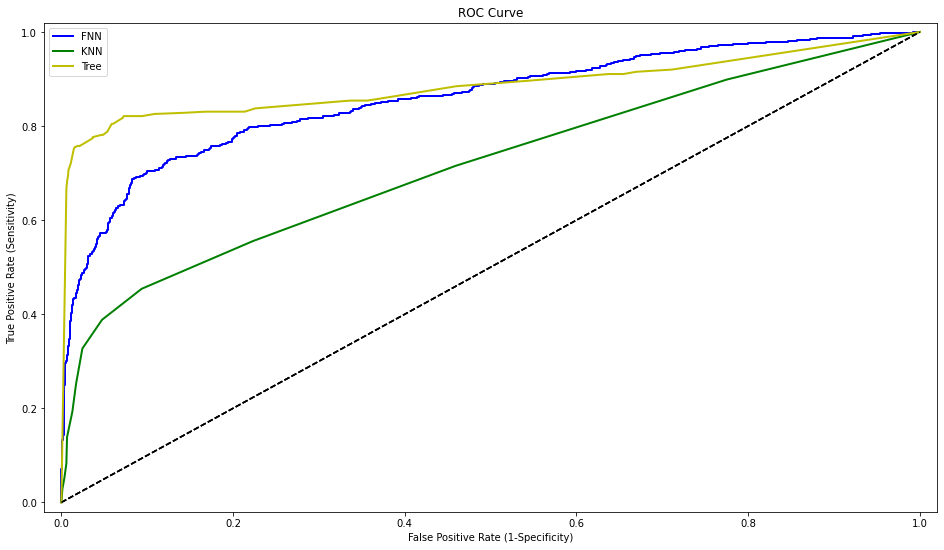

In [114]:
pred_probs_fnn = cv_predictions_fnn[:,1]
pred_probs_knn = cv_predictions_knn[:,1]
pred_probs_tree = cv_predictions_tree[:,1]

fpr_fnn, tpr_fnn, thresholds_fnn = metrics.roc_curve(y_train, pred_probs_fnn)
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(y_train, pred_probs_knn)
fpr_tree, tpr_tree, thresholds_tree = metrics.roc_curve(y_train, pred_probs_tree)

def plot_roc(fpr, tpr, label=None, col='b'):
    plt.plot(fpr, tpr, col, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.xlim((-0.02,1.02))
    plt.ylim((-0.02,1.02))
    plt.title('ROC Curve')

plt.figure(figsize=(16,9))
plot_roc(fpr_fnn, tpr_fnn, label='FNN', col='b')
plot_roc(fpr_knn, tpr_knn, label='KNN', col='g')
plot_roc(fpr_tree, tpr_tree, label='Tree', col='y')
plt.legend()
plt.show()

In [115]:
print("CV AUC with best Neural Network: {0}".format(metrics.roc_auc_score(y_train, pred_probs_fnn)))
print("CV AUC with best KNN: {0}".format(metrics.roc_auc_score(y_train, pred_probs_knn)))
print("CV AUC with best Decision Tree: {0}".format(metrics.roc_auc_score(y_train, pred_probs_tree)))

CV AUC with best Neural Network: 0.8580998286693318
CV AUC with best KNN: 0.7160027412906911
CV AUC with best Decision Tree: 0.8851125071387778


The decision tree and neural network seem to perform almost exactly the same! Let's try both on the test data and find out which performs better. 

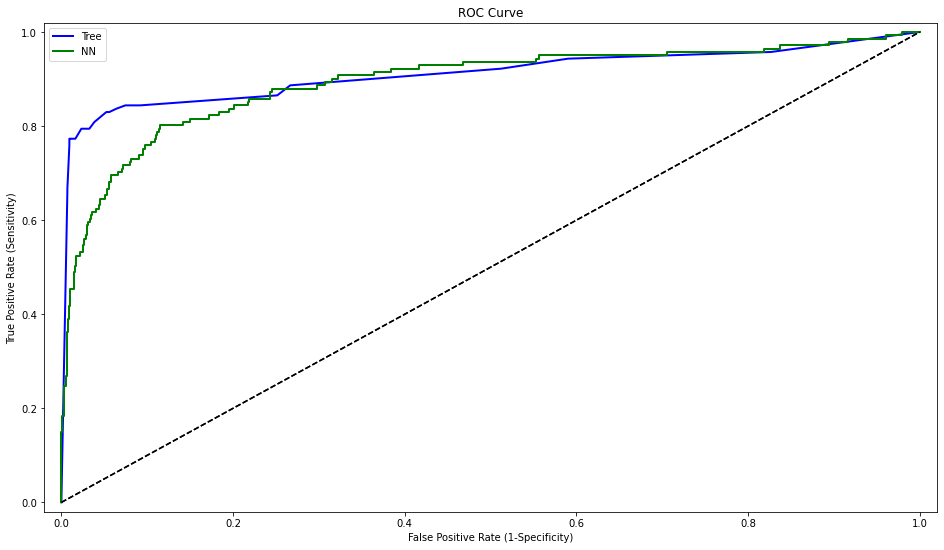

In [116]:
#Fit pipelines on training data
pipe_best_fnn.fit(X_train, y_train['churn'])
pipe_best_tree.fit(X_train, y_train['churn'])

#Predict on test data using fitted pipelines
test_pred_probs_tree = pipe_best_tree.predict_proba(X_test)[:,1]
test_fpr_tree, test_tpr_tree, test_thresholds_tree = metrics.roc_curve(y_test, test_pred_probs_tree)

test_pred_probs_fnn = pipe_best_fnn.predict_proba(X_test)[:,1]
test_fpr_fnn, test_tpr_fnn, test_thresholds_fnn = metrics.roc_curve(y_test, test_pred_probs_fnn)

plt.figure(figsize=(16,9))
plot_roc(test_fpr_tree, test_tpr_tree, label='Tree')
plot_roc(test_fpr_fnn, test_tpr_fnn, label='NN', col='g')
plt.legend()
plt.show()


In [117]:
#AUC Score on the testing data
print("Score on testing data: {0}".format(metrics.roc_auc_score(y_test, test_pred_probs_fnn)))
print("Score on testing data: {0}".format(metrics.roc_auc_score(y_test, test_pred_probs_tree)))

Score on testing data: 0.8928987194412106
Score on testing data: 0.9103443720638381


The Decision Trees's score is higher, so we'll apply it to churn_test in the next section.

# Model Testing
Finally, we can apply our model to the churn_test dataset:

In [123]:
#Read test_csv from hosting site
churn_test = pd.read_csv('http://www.sharecsv.com/dl/08ce6f42b30a9ffdb420ea3a8a585d9e/churn_test.csv')

In [124]:
#Remove cols via previously defined function
test_clean = remove_linearly_dependent(churn_test)

In [120]:
#Impute via IterativeImputer, as with churn_train
imp_test = IterativeImputer(max_iter=100, random_state=0)
test_imputed = test_clean.copy()
test_imputed[:] = imp_test.fit_transform(test_clean)
test_imputed

,state,account_length,international_plan,voice_mail_plan,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churn
0,13.0,92.0,0.0,0.0,197.2,113.0,242.3,116.0,192.0,76.0,11.0,5.000000,2.0,0.0
1,34.0,64.0,1.0,0.0,346.8,55.0,249.5,79.0,275.4,102.0,13.3,9.000000,1.0,1.0
2,20.0,18.0,0.0,0.0,273.6,93.0,114.6,116.0,250.6,120.0,8.2,4.000000,1.0,0.0
3,46.0,63.0,0.0,0.0,278.0,102.0,266.4,114.0,224.1,118.0,13.1,4.000000,4.0,1.0
4,30.0,117.0,1.0,0.0,54.2,100.0,303.2,84.0,171.8,84.0,8.6,4.364006,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,47.0,62.0,0.0,0.0,100.0,98.0,173.5,95.0,218.0,122.0,10.1,4.000000,0.0,0.0
996,47.0,136.0,0.0,1.0,243.3,107.0,226.8,111.0,138.5,117.0,11.0,4.000000,4.0,0.0
997,27.0,49.0,0.0,0.0,189.9,104.0,247.4,120.0,159.8,113.0,10.1,6.000000,1.0,0.0
998,44.0,61.0,0.0,1.0,163.7,78.0,113.2,112.0,134.1,118.0,9.9,4.167981,3.0,0.0


In [125]:
#Use Tree pipe fitted on churn_train training data to obtain probabilities for churn_test and obtain roc curve metrics
test_results = pipe_best_tree.predict_proba(test_imputed.drop(['churn'], axis=1))[:,1]
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(test_imputed['churn'], test_results) #Curve on testing data

In [126]:
print("Score on testing data: {0}".format(metrics.roc_auc_score(test_imputed['churn'], test_results)))

Score on testing data: 0.8447435992701393


Unfortunately, the price we have to pay for using PCA is a hard to interpret model. Since PCA projects the input onto a lesser-dimensional space, the features that the model (MLP or Decision Tree) uses to classify input don't correspond to the original features, so we can't rank the original features in their importance.  
This concludes the practical part of the notebook.

# Theoretical part

In [27]:
from sklearn import datasets
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn import decomposition
%matplotlib inline

In [7]:
faces = fetch_olivetti_faces()

D,y = faces.data, faces.target

print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

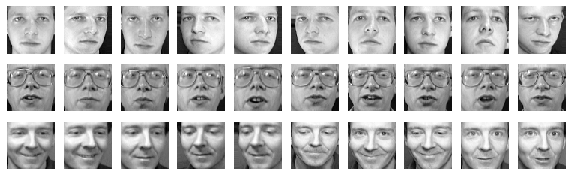

In [8]:
# Original faces
fig = plt.figure(figsize=(10, 3))

# Each row represents one picture. Below 30 pictures are the first 30 rows.
for i in range(30):
    ax = plt.subplot2grid((3, 10), (int(i/10), i-int(i/10)*10))
    
    ax.imshow(D[i,:].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

# PCA

Scatter plot

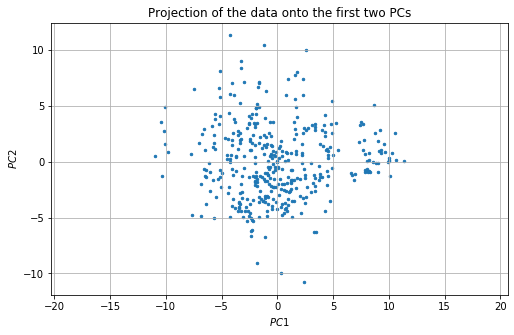

((400, 2), (400, 4096))

In [9]:
# Scatter plot of PCA (r=2)
pca = PCA(n_components=2)

D_pc = pca.fit_transform(D)

plt.figure(2, figsize=(18, 5))
plt.subplot(1,2,1)
plt.title("Projection of the data onto the first two PCs")

# the scatter plot based on y 
plt.scatter(D_pc[:,0],D_pc[:,1], s=6) 
plt.axis('equal')
plt.grid()
plt.xlabel("$PC1$")
plt.ylabel("$PC2$")
plt.show();

D_pc.shape, D.shape

Image reconstruction

In [10]:
a, b = D.shape # D is a * b  matrixx
u = D.mean(0) # u is 1 * b matrix
    
C = D - np.ones((a,1)) * u.T # Center the matrix D for PCA
    
U, s, Vᵀ = np.linalg.svd(C,full_matrices=True) # SVD decomposition

def img_compress(D,r):
    a, b = D.shape # D is a * b  matrixx
    u = D.mean(0) # u is 1 * b matrix
    
    C = D - np.ones((a,1)) * u.T # Center the matrix D for PCA
    
    U, s, Vᵀ = np.linalg.svd(C,full_matrices=True) # SVD decomposition
    reconstimg = np.matrix(U[:, :r]) @ np.diag(s[:r]) @ np.matrix(Vᵀ[:r, :]) + np.ones((a,1)) * u.T # Lower dimension: Image Compression

    return reconstimg

Latent space(=eigenface) of PCA when r=2

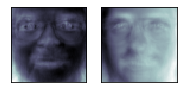

In [11]:
pca = decomposition.PCA(n_components=2, whiten=True)
pca.fit(D)

fig = plt.figure(figsize=(16,6))
for i in range(2):
    ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(faces.images[0].shape), cmap=plt.cm.bone)

Latent space(=eigenface) of PCA when r=5

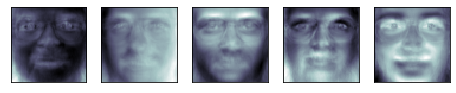

In [12]:
pca = decomposition.PCA(n_components=5, whiten=True)
pca.fit(D)

fig = plt.figure(figsize=(16,6))
for i in range(5):
    ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(faces.images[0].shape), cmap=plt.cm.bone)

The reconstruction of the faces with the indices: 0, 10, 20 using different ranks

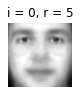

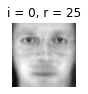

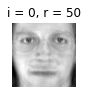

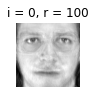

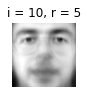

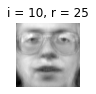

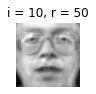

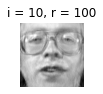

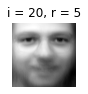

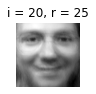

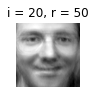

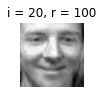

In [13]:
# Faces with the indices: 0, 10, 20 with different ranks

for i in [0,10,20]:
    for r in [5,25,50,100]:
        ax = plt.subplot2grid((3, 4), (int(i/10), i-int(i/10)*10))    
        ax.imshow(img_compress(D,r)[i,:].reshape(64, 64), cmap=plt.cm.gray)
        ax.axis('off')
        
        face = "i = %s," % i
        title = " r = %s" % r
        ax.set_title(face + title)
        plt.show()

# SVD

In [14]:
# Use truncated SVD
U, s, Vᵀ = np.linalg.svd(D,full_matrices=True)
X = Vᵀ.T[:,0:2]
Y = U[:,0:2]*s[0:2]

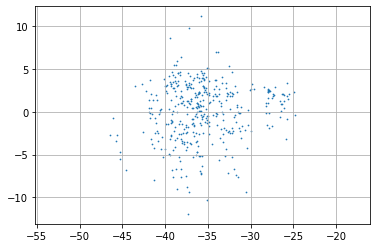

In [15]:
# Scatter plot when r=2 
plt.scatter((Y)[:, 0], (Y)[:, 1],  s=0.5);
plt.axis('equal')
plt.grid()

Latent space of SVD when r = 2

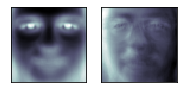

In [16]:
U, s, Vᵀ = np.linalg.svd(D,full_matrices=True)
X = Vᵀ.T[:,0:2]
Y = U[:,0:2]@s[0:2]

fig = plt.figure(figsize=(16,6))
for i in range(2):
    ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    ax.imshow(X.T[i].reshape(faces.images[0].shape), cmap=plt.cm.bone)

Latent space of SVD when r = 5

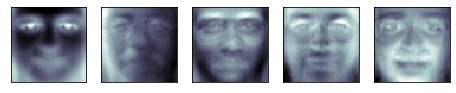

In [17]:
fig = plt.figure(figsize=(16,6))
X = Vᵀ.T[:,0:5]
Y = U[:,0:5]@s[0:5]
for i in range(5):
    ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    ax.imshow(X.T[i].reshape(faces.images[0].shape), cmap=plt.cm.bone)

Faces with the indices: 0, 10, 20 with different ranks

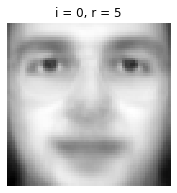

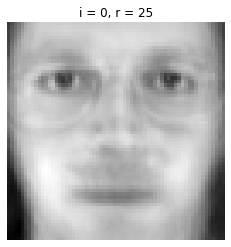

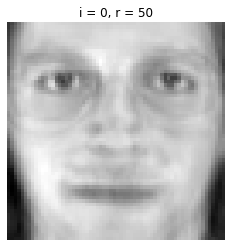

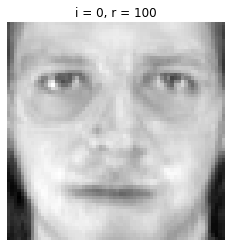

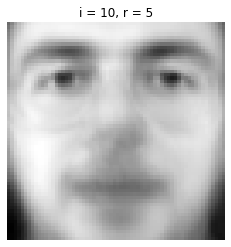

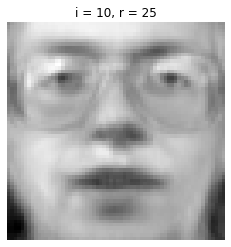

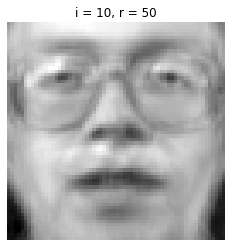

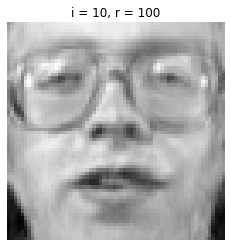

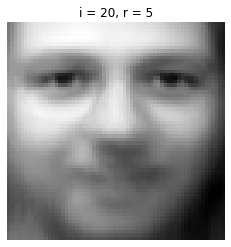

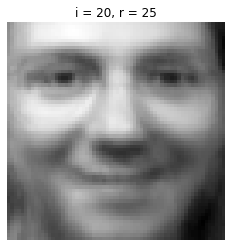

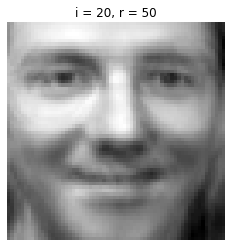

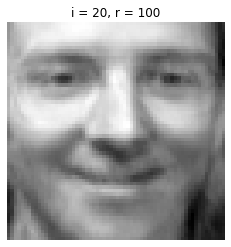

In [18]:
fig = plt.figure(figsize=(10, 3))
for f in [0,10,20]:
    for r in [5,25,50,100]:
        X = Vᵀ.T[:,0:r]
        Y = U[:,0:r]*s[0:r]
        plt.imshow((Y@X.T)[f,:].reshape(64, 64), cmap=plt.cm.gray)
        plt.axis('off')
        face = "i = %s," % f
        title = " r = %s" % r
        plt.title(face + title)
        plt.show()

# K-means

In [20]:
def RSS(D,X,Y):
    return np.sum((D-Y@X.T)**2)  

def init_centroids_pp(D,r):
    n,d = D.shape
    i = np.random.randint(low=1, high=n, size=1)[0]
    X = np.array([D[i,:]]).T
    
    while X.shape[1] < r:
        i = np.random.randint(low=1, high=n, size=1)[0]
        X = np.append(X,np.array([D[i,:]]).T,axis=1)      
    return X

In [21]:
def getY(labels):
    Y = np.zeros((len(labels), max(labels)+1))
    for i in range(0, len(labels)):
        Y[i, labels[i]] = 1
    return Y
def update_centroid(D,Y):
    cluster_sizes = np.diag(Y.T@Y).copy()
    cluster_sizes[cluster_sizes==0]=1
    return D.T@Y/cluster_sizes
def update_assignment(D,X):
    dist = np.sum(D**2,1).reshape(-1,1)  - 2* D@X + np.sum(X**2,0)
    labels = np.argmin(dist,1)
    return getY(labels)
def kmeans(D,r, X_init, epsilon=0.00001, t_max=10000):
    X = X_init.copy()
    Y = update_assignment(D,X)
    rss_old = RSS(D,X,Y) +2*epsilon
    t=0
    #Looping as long as difference of objective function values is larger than epsilon
    while rss_old - RSS(D,X,Y) > epsilon and t < t_max-1:
        rss_old = RSS(D,X,Y)
        X = update_centroid(D,Y)
        Y = update_assignment(D,X)
        t+=1
    print(t,"iterations")
    return X,Y

Scatter plot for KMeans (r=2)

18 iterations


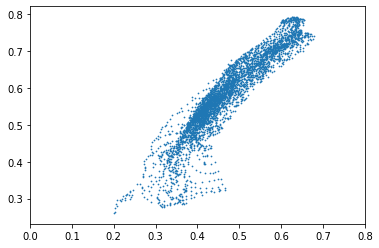

In [22]:
r = 2
X_init = init_centroids_pp(D,r)
X,Y = kmeans(D,r, X_init) # Y : class / X.T = The cordinate of centroids

plt.scatter(X[:,0], X[:,1],  s=0.5)
plt.xlim(0,0.8);

Latent space(=centroids) of Kmeans when r = 2

7 iterations


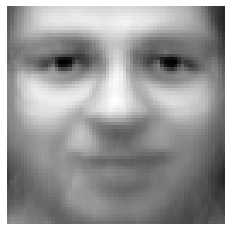

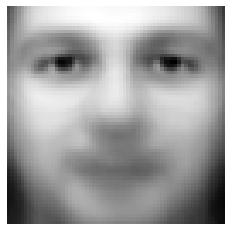

In [23]:
r = 2
X_init = init_centroids_pp(D,r)
X,Y = kmeans(D,r, X_init) # Y : class / X.T = The cordinate of centroids

for i in range(2):
    plt.imshow((X.T)[i,:].reshape(64, 64), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show();

Latent space(=centroids) of Kmeans when r = 5

9 iterations


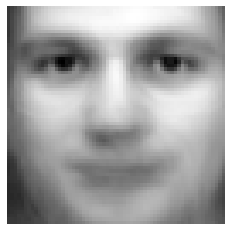

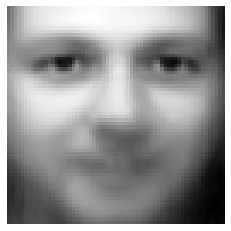

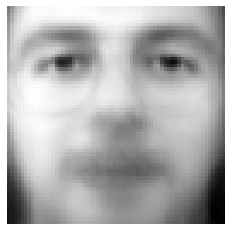

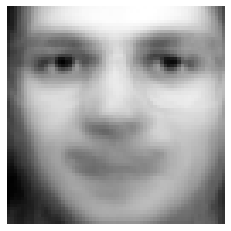

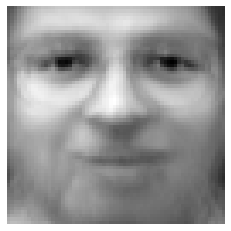

In [24]:
r = 5
X_init = init_centroids_pp(D,r)
X,Y = kmeans(D,r, X_init) # Y : class / X.T = The cordinate of centroids

for i in range(5):
    plt.imshow((X.T)[i,:].reshape(64, 64), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show();

Faces with the indices: 0, 10, 20 with different ranks

20 iterations


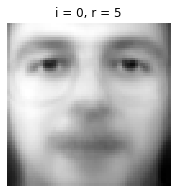

10 iterations


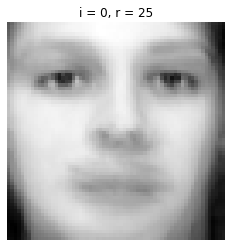

9 iterations


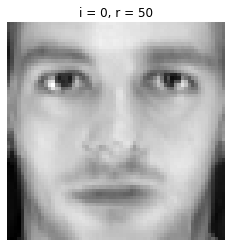

5 iterations


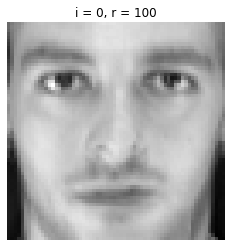

17 iterations


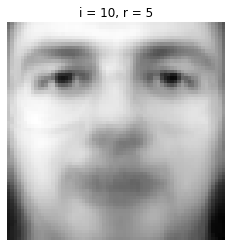

9 iterations


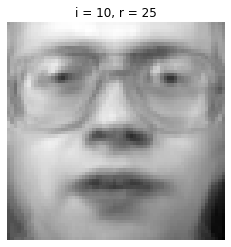

13 iterations


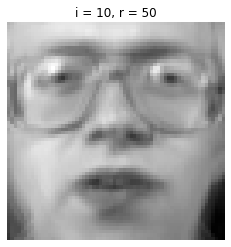

6 iterations


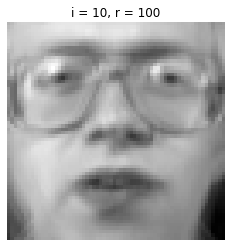

25 iterations


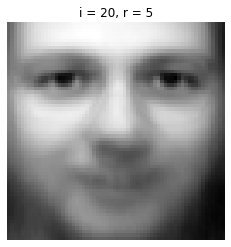

9 iterations


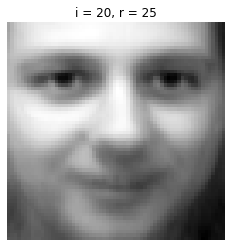

8 iterations


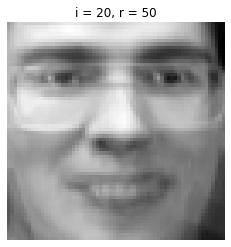

5 iterations


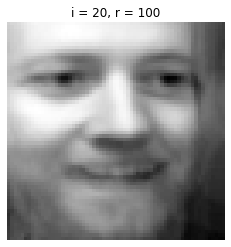

In [26]:
fig = plt.figure(figsize=(10, 3))
for f in [0,10,20]:
    for r in [5,25,50,100]:
        X_init = init_centroids_pp(D,r)
        X,Y = kmeans(D,r, X_init)
        
        plt.imshow((Y@X.T)[f,:].reshape(64, 64), cmap=plt.cm.gray)
        plt.axis('off')
        face = "i = %s," % f
        title = " r = %s" % r
        plt.title(face + title)
        plt.show()

# Conclusion

The Olivetti faces dataset consists of ten different images of each of 40 distinct subjects. It is of matrix form with 4096 dimensions and 40 classes (= (40 x 10) x 4096 matrix). We can say that each row in the matrix represents one single image and one point in the 4096 dimensional coordinate system.

The PCA method finds the directions of the first few largest variations of points in that coordinate system, define the new axes as those directions and projects the original points on the new axes in order to reduce dimensionality (=image compression).

The SVD method is to find a low-rank approximation matrix to best represent the original dataset using truncated SVD.

The K-means method represents all data points (=400 images) in clusters via r number of cluster centroids (r images). That is, each data point is assigned to the cluster of its nearest centroid.

<Similiarities & Differences>

Both PCA and SVD methods take the first r most important features of the whole dataset, which are the features all images commonly have, and the reconstruction error is minimized in both methods. They are basically identical methods and reduce dimensions of the original data. On the other hand, the K-Means method doesn’t reduce dimensions of the original data and it is a heuristic algorithm since it can return a local minimum.

Due to the differences between PCA and the K-means method, visualizations of faces are expressed in a different way. The first few principle components capture the most important features faces commonly have, which is, for example, the lighting condition (bright or light), while the remaining principle components capture more detailed features of the faces such as the nose, eyebrows or eyes. The last few principle components can be seen as noise. Since the reconstruction of images using PCA is equal to combining the "average face" and the principle components, visualizations of faces tend to converge to the average face of all faces as ‘r’ decreases but the more ‘r’ is, the more accurate are the reconstructions of images.

However, K-means method is merely to assigning original points (in 4096 dimensional coordinate system) to their nearest centroid point while the nearest centroid of a point is defined as the point whose distance to another is the least. Since the K-means method can not reduce dimensions, the coordinates of all features(=4096) in the original data are considered in order to calculate the distance between a centroid and a point. That means that K-means is susceptible to noise. For example, faces in same class (=same face with different lighting and angle) can be reconstructed as different faces to each other from the K-means method, while from the PCA or SVD method they are similar. We can see how the K-means method works poorly when r=100. Additionally, unlike the PCA or SVD method, if r is increased, the reconstructions of the images from the K-means method does not always become more accurate since important features and unimportant features (=noise) are equally treated.

Lastly, in the case of PCA and SVD, the approximation matrix is derived from the truncated right singular vectors which represent their latent space. The reconstruction of faces in r-dimensional latent space in both methods comes from a linear combination of eigenfaces together with average face of overall faces which can enable different images to be differentiated. On the other hand, k-means does not select features nor create ‘eigenfaces’ but merely finds r average faces for r clusters to which other faces are the closest / the most similar, while preserving all features.

This concludes the theoretical part and our notebook.